In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from scipy import sparse

Since reviews are often prone to abuse, we want to look at the ratings and gather which ones are not worthwhile. Fortunately, we are provided with user votes as helpful or unhelpful.

In [2]:
reading_reviews = False
helpful_reviews = []
unhelpful_reviews = []
#I have enough memory to keep the text in memory rather than having to read from disk every time
with open('amazon-meta.txt') as f:
    lines = f.readlines()
    
#if memory is very limited:
# def lines():
#     with open('amazon-meta.txt') as f:
#         return f.readlines()
#then find and replace lines -> lines()
    
for line in lines:
    if reading_reviews:
        try:
            pd.Timestamp(line.split()[0])
        except:
            if len(line) < 1:
                flag = False
        else:
            votes = line.split('votes:')[1].strip().split()[0]
            helpful = line.split('helpful:')[1].strip()
            if int(votes) == 0:
                helpful_ratio = 1
            else:
                helpful_ratio = int(helpful)/int(votes)
            if helpful_ratio < 0.2:
                unhelpful_reviews.append(int(line.split('rating: ')[1][0]))
            else:
                helpful_reviews.append(int(line.split('rating: ')[1][0]))
    elif line.strip().startswith('reviews:'):
        reading_reviews = True
            
print(helpful_reviews[:10])
print(unhelpful_reviews[:10])

[5, 5, 5, 4, 5, 5, 4, 4, 4, 5]
[2, 4, 1, 1, 3, 5, 5, 5, 5, 1]


([array([0.06635359, 0.04964079, 0.07717438, 0.18559735, 0.62123388]),
  array([0.15217256, 0.09084721, 0.1221772 , 0.17776353, 0.4570395 ])],
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <a list of 2 Lists of Patches objects>)

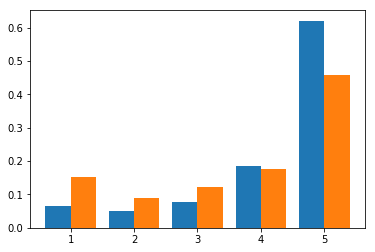

In [3]:
plt.hist([helpful_reviews,unhelpful_reviews], bins=[0.5,1.5,2.5,3.5,4.5,5.5], normed=True)

The plot suggests that positive reviews are more likely to be marked as helpful than negative reviews. Both helpful and unhelpful reviews are biased toward a rating of 5.

---

We will need to first aggregate all book category labels before we can analyze how to reduce the number of categories.

In [4]:
all_categories = pd.Series()
book = False
books = 0
for line in lines:
    if 'group:' in line:
        book = 'Book' in line
        books += book
    if book:
        if line.strip().startswith('|'):
            try:
                all_categories[line.strip()]
            except:
                all_categories[line.strip()] = 1
            else:
                all_categories[line.strip()] += 1
                
print(all_categories.sort_values(ascending=False).head(10))
print("There are {} book records.".format(books))
print("There are {} categories with less than 5 associated records.".format(sum(all_categories < 5)))
print("There are {} unique categories.".format(len(all_categories)))
print("There are {} category labels across all records.".format(sum(all_categories)))

|[265523]|Amazon.com Stores[285080]|Home & Office[764512]|Business & Investing Books[767740]|General[767880]    18438
|Books[283155]|Subjects[1000]|Business & Investing[3]|General[2612]                                             18436
|Books[283155]|Subjects[1000]|Reference[21]|General[408268]                                                     13701
|Books[283155]|Subjects[1000]|Biographies & Memoirs[2]|General[2375]                                            12241
|Books[283155]|Subjects[1000]|Nonfiction[53]|Social Sciences[11232]|Sociology[11288]|General[11289]             11779
|Books[283155]|Subjects[1000]|Literature & Fiction[17]|General[10125]|Contemporary[10129]                       11446
|Books[283155]|Subjects[1000]|Children's Books[4]|Ages 4-8[2785]|General[170062]                                11439
|Books[283155]|Subjects[1000]|Nonfiction[53]|Education[10605]|General[10635]                                     8759
|Books[283155]|Subjects[1000]|Computers & Internet[5]|Ge

In order to reduce the number of categories, we will cluster the labels into 1400 clusters (~10 percent of the original number of categories.) In order to analyze the labels, we will use scikit-learn's CountVectorizer to break the text down into three character chunks and get into a matrix that the clustering algorithm can read.

In [5]:
from sklearn import cluster
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
vectorizer = CountVectorizer(ngram_range=(2,4), analyzer='char', min_df = 5, max_df = 0.9)
X = vectorizer.fit_transform(all_categories.index)

In [13]:
clusterer = cluster.AgglomerativeClustering(n_clusters=1400)
clusters = clusterer.fit_predict(X.toarray())

In [14]:
df = pd.DataFrame({'num_records':all_categories})
df['cluster'] = clusters

In [15]:
df.head()

,num_records,cluster
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368],364,221
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370],315,221
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Wicca[12484],490,1017
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Witchcraft[12486],527,1017
|Books[283155]|Subjects[1000]|Home & Garden[48]|Crafts & Hobbies[5126]|General[5144],5108,43


Now that we have combined categories we will have fewer category entries for each product. We will need to search the text one more time to find out how many entries there are now.

In [16]:
book = False
n_clusters = []
for line in lines:
    if 'group:' in line:
        book = 'Book' in line
        assoc_clusters = set()
    elif book:
        if line.strip().startswith('|'):
            assoc_clusters.add(df.loc[line.strip(), 'cluster'])
        elif len(line.strip()) < 1:
            book = False
            n_clusters.append(len(assoc_clusters))

In [17]:
print(sum(n_clusters)/sum(all_categories))

0.8267381966203555


This is fewer category entries than we are hoping for. Let's see if we might split some of the larger clusters up again.

In [21]:
by_cluster = df.groupby('cluster').sum()
by_cluster.sort_values('num_records', ascending=False).head(10)

,num_records
cluster,
241,26635
1108,24844
872,24438
425,23773
126,18030
239,16829
146,16753
350,13813
523,13387


In [22]:
df.loc[df.cluster == 241]

,num_records,cluster
|Books[283155]|Subjects[1000]|Business & Investing[3]|General[2612],18436,241
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Economic History[2589],439,241
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Development & Growth[2585],625,241
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Economic Policy & Development[2588],928,241
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|International[2594],517,241
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Labor & Industrial Relations[2595],543,241
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Money & Monetary Policy[2598],164,241
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|General[2592],1669,241
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Econometrics[2586],170,241
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Natural Resources[1043856],501,241


The largest category is notably not in economics, so we can give it it's own cluster.

In [27]:
df.loc['|Books[283155]|Subjects[1000]|Business & Investing[3]|General[2612]','cluster'] = 241.1
df.loc[(df.cluster > 240)&(df.cluster < 242)]

,num_records,cluster
|Books[283155]|Subjects[1000]|Business & Investing[3]|General[2612],18436,241.1
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Economic History[2589],439,241.0
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Development & Growth[2585],625,241.0
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Economic Policy & Development[2588],928,241.0
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|International[2594],517,241.0
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Labor & Industrial Relations[2595],543,241.0
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Money & Monetary Policy[2598],164,241.0
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|General[2592],1669,241.0
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Econometrics[2586],170,241.0
|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Natural Resources[1043856],501,241.0


In [36]:
econs = [x for x in df.loc[df.cluster == 241].index if 'Policy' in x]
econs

['|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Economic Policy & Development[2588]',
 '|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Money & Monetary Policy[2598]',
 '|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|Commercial Policy[2582]']

In [38]:
df.loc[econs] = 241.2

In [39]:
df.loc['|Books[283155]|Subjects[1000]|Business & Investing[3]|Economics[2581]|General[2592]'] = 241.3

In [40]:
book = False
n_clusters = []
for line in lines:
    if 'group:' in line:
        book = 'Book' in line
        assoc_clusters = set()
    elif book:
        if line.strip().startswith('|'):
            assoc_clusters.add(df.loc[line.strip(), 'cluster'])
        elif len(line.strip()) < 1:
            book = False
            n_clusters.append(len(assoc_clusters))
            
print(sum(n_clusters)/sum(all_categories))

0.8300992342721698


We have dropped 17% of the total category entries, and have reduced the number of categories to 1403, or just over 10 percent of the original.

If it is not acceptable to have cluster numbers instead of descriptive labels we could have humans attach labels for each of the clusters, or if that is prohibitively expensive we could try to rebuild the categorization from scratch by parsing the similarities within each cluster.

---

1. How would build the product categorization from scratch, using similar/co-purchased information?
    * I would use heirarchical clustering, similar to above. However, without the categorization data we have here, I would use the similar/co-purchasing information to learn the distance between products. I would most likely make a separate tree for each of the 'group' labels given, since i.e. video labels are likely not going to be in the same category tree as book labels.
    
1. **Product thinking**  
    Now, put on your 'product thinking' hat.
    
    a. Is it a good idea to show users the categorization hierarchy for items?  
    b. Is it a good idea to show users similar/co-purchased items?  
    c. Is it a good idea to show users reviews and ratings for items?  
    d. For each of the above, why? How will you establish the same?  
    
    * I think the categorization heirarchy as given here is not helpful for users to see. It is confusing and may distract users.
    
    Similar items, by contrast, can certainly be helpful to show to users. Users may find a different item that is more in line with their needs, or they may have an easier time finding products that go together.
    
    Reviews are helpful for users to see because it makes the user feel more confident in the product they are buying to know that people like them are satisfied with the product.